In [9]:
%pylab inline
import netCDF4 as nc
import cartopy.crs as ccrs
from pathlib import Path


Populating the interactive namespace from numpy and matplotlib


In [10]:
data_names = ['tas_Amon_ACCESS1-0_historical*.nc', # 3.8
    'tas_Amon_bcc-csm1-1_historical*.nc', # 2.8 
    'tas_Amon_BNU-ESM_historical*.nc', # 4.1
    'tas_Amon_CanESM2_historical*.nc', # 3.7
    'tas_Amon_CCSM4_historical*.nc', # 2.9
    'tas_Amon_CESM1-BGC_historical*.nc', # UNK
    'tas_Amon_CESM1-CAM5_historical*.nc', # UNK
    'tas_Amon_FIO-ESM_historical*.nc', # UNK  
    'tas_Amon_CMCC-CESM_historical*.nc', # UNK
    'tas_Amon_CMCC-CM_historical*.nc',#
    'tas_Amon_CMCC-CMS_historical*.nc', #
    'tas_Amon_EC-EARTH_historical*.nc', #
    'tas_Amon_FGOALS-g2_historical*.nc', #
    'tas_Amon_FIO-ESM_historical*.nc', #
    'tas_Amon_GFDL-CM2p1_historical*.nc', #
    'tas_Amon_GFDL-CM3_historical*.nc', # 4.0
    'tas_Amon_GISS-E2-H_historical*.nc', # 2.3
    'tas_Amon_HadCM3_historical*.nc', # 0
    'tas_Amon_HadGEM2-ES_historical*.nc', # 4.6
    'tas_Amon_inmcm4_historical*.nc', # 2.1
    'tas_Amon_IPSL-CM5A-LR_historical*.nc', # 4.1
    'tas_Amon_MIROC-ESM-CHEM_historical*.nc', #4.7
    'tas_Amon_MIROC4h_historical*.nc', # 0
    'tas_Amon_MIROC5_historical*.nc', #2.7
    'tas_Amon_MPI-ESM-LR_historical*.nc', # 3.6
    'tas_Amon_MRI-CGCM3_historical*.nc', # 2.6
    'tas_Amon_NorESM1-M_historical*.nc'] # 2.8

In [19]:
cs =  [3.8, 2.8, 4.1, 3.7, 2.9, 
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       4.0, 2.3, 0, 4.6, 2.1, 4.1, 4.7, 0, 2.7, 3.6, 2.6,  2.8]

In [20]:
def grid_areas(ds):
    lats = ds.variables['lat'][:]
    res = 180/ds.variables['lat'].shape[0]

    def sin_d(degrees):
        return np.sin(degrees / 180 * np.pi)

    s = (sin_d(lats + (res / 2)) - sin_d(lats - (res / 2))) / 2
    s[0] = 1 -  sin_d(90 - (res / 2))
    s[-1] = 1 - sin_d(90 - res / 2)
    areas = np.zeros([ds.variables['lat'].shape[0], ds.variables['lon'].shape[0]])
    for i in range(ds.variables['lon'].shape[0]):
        areas[:, i] = s / ds.variables['lon'].shape[0]
        
    return areas

In [21]:
def Detrend(input_data):
    p=40
    q=20
    n = int(np.floor(len(input_data)/12))
    data_m = np.zeros([12,n])
    data_m_temp=np.zeros([12,n-p,p])
    data_m_mean = np.zeros([12,n-p])
    data_m_detrend_point = np.zeros([12,n-p])
    for k in range(0,12):
        data_m[k] = [input_data[e*12+k] for e in range(0,n)]
        for j in range(0,n-p):
            data_m_temp[k][j]=[data_m[k][i+j] for i in range(0,p)]
            data_m_mean[k][j]=np.mean(data_m_temp[k][j])
            data_m_detrend_point[k][j] = data_m[k][j+q]-np.mean(data_m_temp[k][j])
    data_all=np.transpose(data_m_detrend_point)
    data_all=np.ravel(data_all)
    return data_all

In [22]:
fast_variable = np.zeros(len(data_names))

for i in range(len(data_names)):
    #filename = '/Users/g/Documents/CMIP5/'+ data_names[i]
    #ds = nc.Dataset(filename) 
    #temperatures = ds['tas'][:,:,:] 
    
    data_path = Path('/Users/g/Documents/CMIP5/')
    files = sorted(data_path.glob(data_names[i]))
    data = [nc.Dataset(f) for f in files]
    temperatures = np.concatenate([d['tas'][:] for d in data])
    
    temp_time = np.sum(temperatures * grid_areas(data[0]), axis=(1,2))
    
    fast_variable[i] = np.std(Detrend(temp_time))

In [23]:
fast_variable

array([0.16518472, 0.17105998, 0.20518865, 0.19233936, 0.18688648,
       0.17248759, 0.14154842, 0.16373587, 0.21531884, 0.13680638,
       0.14322082, 0.12972169, 0.10954128, 0.16373587, 0.21898467,
       0.21160013, 0.11320238, 0.1735979 , 0.1695811 , 0.1107912 ,
       0.16950906, 0.14530507, 0.10616433, 0.1824974 , 0.17380728,
       0.14966543, 0.14835025])

(2, 5)

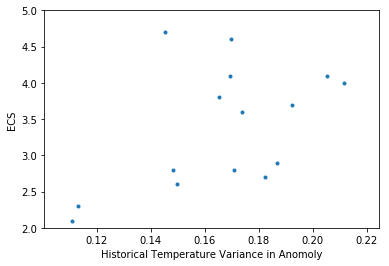

In [25]:
plt.plot(fast_variable,cs, '.')
plt.ylabel('ECS')
plt.xlabel('Historical Temperature Variance in Anomoly')
plt.ylim([2,5])

(2, 5)

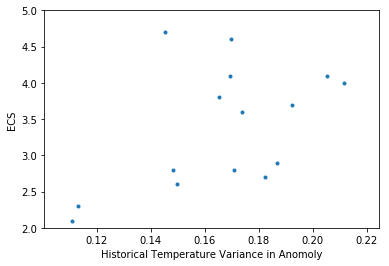

In [28]:
plt.plot(fast_variable,cs, '.')
plt.ylabel('ECS')
plt.xlabel('Historical Temperature Variance in Anomoly')
plt.ylim([2,5])